In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
hh_df = pd.read_csv("data/faps_household_puf.csv")

item_df = pd.read_csv("data/faps_fahitem_puf.csv")
nutrient_df = pd.read_csv("data/faps_fahnutrients.csv")

In [3]:
ID_VARIABLES = ["hhnum", "eventid", "itemnum"]
REQUIRED_VARIABLES = [*ID_VARIABLES, "totgramsedible", "totsug"]

food_df = item_df.merge(nutrient_df[REQUIRED_VARIABLES], how="left", on=ID_VARIABLES)

In [4]:
hh_df = hh_df[(hh_df["numguests"] == 0) & (hh_df["hhsizechange"] == 0)]

In [5]:
import enum


class SNAPNowAdmin(enum.Enum):
    NO_MATCH = 0
    CONFIRMED_SNAP = 1
    CONFIRMED_NON_SNAP = 2
    VALID_SKIP = -996


hh_df = hh_df[
    (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value)
    | (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_NON_SNAP.value)
]

In [6]:
hh_df["snap_status"] = hh_df["snapnowadmin"].replace(
    {SNAPNowAdmin.CONFIRMED_SNAP.value: 1, SNAPNowAdmin.CONFIRMED_NON_SNAP.value: 0}
)

/var/folders/6r/g5w3tmhx0tj1ygxtm4032mk40000gn/T/ipykernel_81759/2261300958.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hh_df["snap_status"] = hh_df["snapnowadmin"].replace(


In [7]:
food_df = food_df[(food_df["totgramsedible"] > 0) & (food_df["totsug"].notna())]

# Exploratory Data Analysis Question 1

**_Are SNAP households more likely to acquire sugary foods than non-SNAP households?_**


In [8]:
edaq1_food_df = food_df.copy()

In [9]:
edaq1_food_df["sugar_amount"] = (edaq1_food_df["totsug"] / 100) * edaq1_food_df["totgramsedible"]
edaq1_food_df["sugar_density"] = edaq1_food_df["totsug"]

In [10]:
hh_sugar_df = (
    edaq1_food_df.groupby("hhnum")
    .agg(total_sugar_amount=("sugar_amount", "sum"), total_amount=("totgramsedible", "sum"))
    .reset_index()
)
hh_sugar_df["sugar_share"] = hh_sugar_df["total_sugar_amount"] / hh_sugar_df["total_amount"]

In [11]:
hh_sugar_df = hh_sugar_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

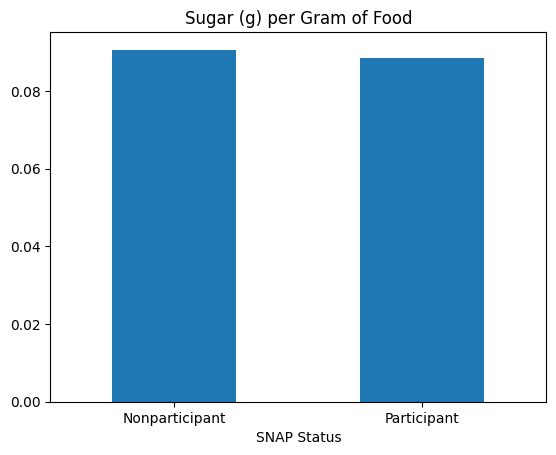

In [12]:
ax = hh_sugar_df.groupby("snap_status")["sugar_share"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("Sugar (g) per Gram of Food")
ax.set_xlabel("SNAP Status")

plt.show()

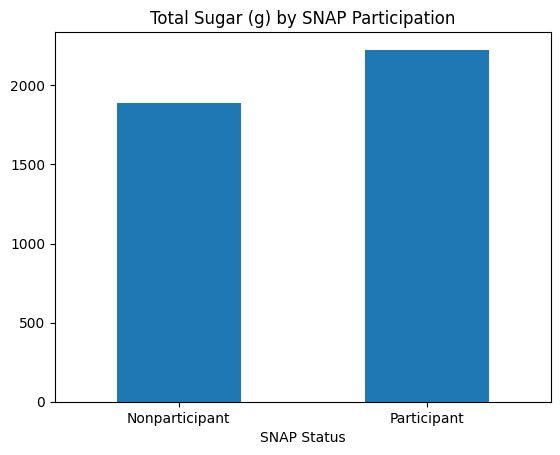

In [13]:
ax = hh_sugar_df.groupby("snap_status")["total_sugar_amount"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("Total Sugar (g) by SNAP Participation")
ax.set_xlabel("SNAP Status")

plt.show()

In [14]:
HIGH_SUGAR_THRESHOLD = 22.5

food_df["high_sugar_status"] = (food_df["totsug"] > HIGH_SUGAR_THRESHOLD).astype(int)

high_sugar_share = food_df.groupby("hhnum")["high_sugar_status"].mean().reset_index()
high_sugar_share = high_sugar_share.merge(hh_df[["hhnum", "snap_status"]], on="hhnum")

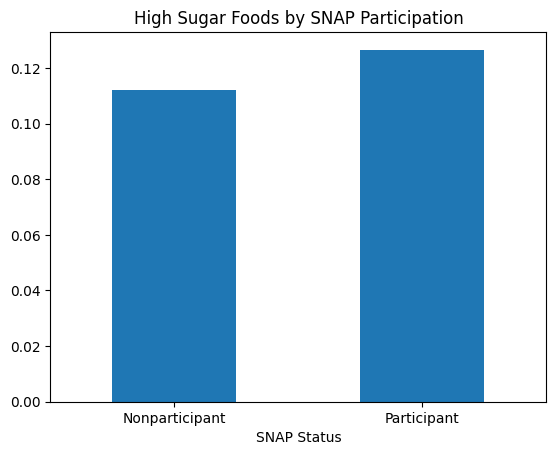

In [15]:
ax = high_sugar_share.groupby("snap_status")["high_sugar_status"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("High Sugar Foods by SNAP Participation")
ax.set_xlabel("SNAP Status")

plt.show()


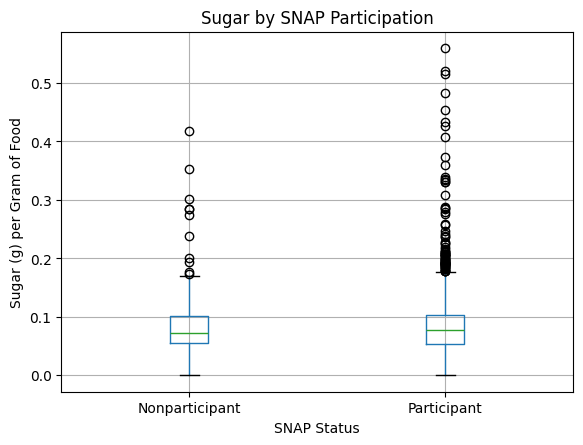

In [20]:
hh_sugar_df.boxplot(column="sugar_share", by="snap_status")

plt.xticks([1, 2], ["Nonparticipant", "Participant"])

plt.title("Sugar by SNAP Participation")
plt.suptitle("")
plt.ylabel("Sugar (g) per Gram of Food")
plt.xlabel("SNAP Status")

plt.show()